### **The Boston Housing Price Dataset**

Here, we will attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as crime rate, local property tax rate and so on. The interesting properties of the dataset are listed below.


*   It has relatively few data points (506: 404 training; 102 testing).
*   Each feature in the input data has a different scale (i.e. some values are in proportions[0,1], some in the range of the natural numbers).




In [1]:
# Loading the Boston Housing Dataset
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Let's look at the data:
print("Training data shape: ", train_data.shape)
print("Testing data shape: ", test_data.shape)

65536/57026 [==================================] - 0s 0us/step
Training data shape:  (404, 13)
Testing data shape:  (102, 13)


It should be noted that we have 13 numerical features such as per capita crime rate, average no. of rooms per dwelling, accessibility to highways, and so on.

In [2]:
print("Targets: ", train_targets) #values of the pre-occupied homes, in thousands of dollars

Targets:  [15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6


We can observe that,  the prices are typically between 10K to 50K. I don't know it sounds cheap or not: remember that this was the mid-1970s, and these prices aren't adjusted for inflation.

### **Preparing the data**

If we feed the dataset in the current form it will create a problem for the designed neural network due to the wide different ranges though the network has the ability to automtically adapt to such heterogeneous data. But the it would make the learning very difficult. To deal with such data we will perform feature-wise normalization through the following equation:

$X = (X-mean)/std$

With this all the features will be centered around 0 and has a unit standard deviation.

In [3]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#test data
test_data -=mean
test_data /=std

Note that the quantities used for normalizing the test data are computed using the training data. You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

### Building the network

As there are very few samples are available, a very small network with two hidden layers, each with 64 units in sufficient. In general small training data samples leads to worse overfitting and it is one of the way to mitigate that.

In [4]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(loss='mse',
                optimizer='rmsprop',
                metrics=['mae'])
  return model

This network ends with a single unit and no activation (i.e. linear layer). This is a typical setup for scalar regression (a regression to predict a single continuous value). Here applying an activation function would constrain the range that the output can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only predict values between 0 and 1. Here, because the last layeris purely linear, the network is free to learn to predict values in any range.

### **Validating our approach with K-fold cross validation**
As our training samples is very tiny if we separate a small part of it and validate the model on that; the validation scores might change a lot depending on the split and returns a high variance in the evaluation score. To prevent that the K-fold cross validation has been performed here.

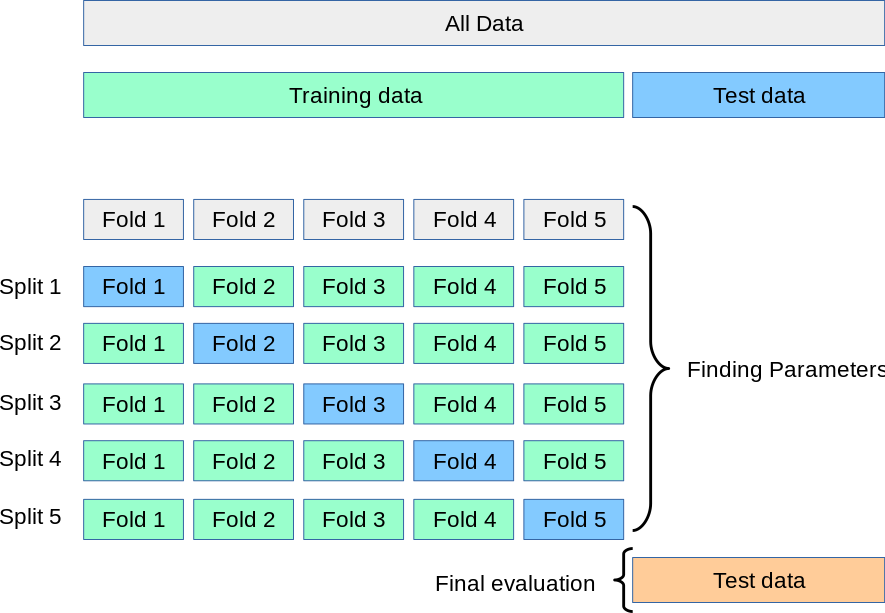

In [17]:
# K-fold validation
import numpy as np

k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print("processing fold #", i)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples] #Prepare the validation data: data from partition K.
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

  partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]], axis=0) #Prepare the training data:data from all other partitions
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]], axis=0)

  model = build_model() #Builds the keras model already compiled
  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size=1, verbose = 0) #Trains the model (in silent mode, verbose = 0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [15]:
print("all_validation_scores: ", all_scores)
print("mean: ", np.mean(all_scores))

all_validation_scores:  []
mean:  nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Saving the validation log at each fold
from keras import backend as K
K.clear_session()
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
  # We can compute the average of the per-epoch MAE scores for all folds.
  # Building the history pf successive mean K-fold validaition scores
  #average_mae_history = [np.mean(x[i] for x in all_mae_histories) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [21]:
  # We can compute the average of the per-epoch MAE scores for all folds.
  # Building the history pf successive mean K-fold validaition score
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

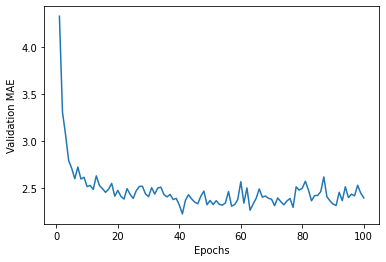

In [22]:
# Ploting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

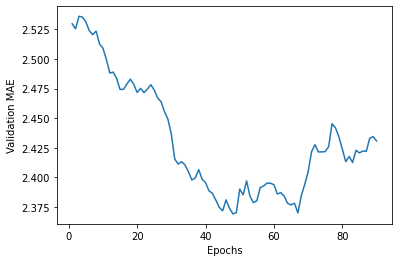

In [24]:
# Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
# Training the final model
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("Test_mae_score: ",test_mae_score)

4/4 [==============================] - 0s 4ms/step - loss: 16.4208 - mae: 2.4787
Test_mae_score:  2.4787466526031494
